In [2]:
!git clone https://github.com/LoadingByte/are-gnn-defenses-robust.git

Cloning into 'are-gnn-defenses-robust'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 71 (delta 9), reused 71 (delta 9), pack-reused 0 (from 0)
Unpacking objects: 100% (71/71), done.


In [3]:
%cd are-gnn-defenses-robust/

/home/wcorcoran/research/2-phase-attack/src/gradient-based/are-gnn-defenses-robust


In [4]:
!chmod +x requirements-install.sh
!./requirements-install.sh

./requirements-install.sh Usage: <cpu|cu102|cu113>


In [9]:
from collections import OrderedDict
import torch

import sys
sys.path.append("..")
import gb

In [10]:
dataset = "cora"
A, X, y = gb.data.get_dataset(dataset)
N, D = X.shape
C = y.max().item() + 1
train_nodes, val_nodes, test_nodes = gb.data.get_splits(y)[0]

A = A.cuda()
X = X.cuda()
y = y.cuda()

/home/wcorcoran/research/2-phase-attack/src/gradient-based/are-gnn-defenses-robust/gb/data.py:43: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  lcc_nodes = np.nonzero(comp_ids == mode(comp_ids)[0])[0]


so far not working...

### Idea:
1. Set budget $b$ and threshold $t$.
2. Run metattack for budget $(1 - t) * b$, get edges
3. Make two adj matrices $A_{clean}$ and $A_{dirty}$
4. Run a similar attack, but budget $t * b$, and loss function:
$$(1 - \alpha) * (L_{clean} - L_{vanilla})^2 + \alpha * L_{dirty}$$
where $\alpha$ is the weight of the dirty adjacency matrix.

In [227]:
import torch.nn.functional as F
torch.manual_seed(42)

fit_kwargs = dict(lr=1e-2, weight_decay=5e-4)
# budget = 1000
budget = 250
t = 0.75
# t = 0.8
# alpha = 0.995
# alpha = 0.1
# alpha = 1
alpha = 0.01

def make_model():
    return gb.model.GCN(n_feat=D, n_class=C, hidden_dims=[16], dropout=0.5).cuda()

aux_model = make_model()
aux_model.fit((A, X), y, train_nodes, val_nodes, progress=False, **fit_kwargs)

A2 = A.clone()

def loss_fn(A_flip, A2):
    A_pert = A2 + A_flip * (1 - 2 * A2)

    ########## Meta-Attack w/ Adam ##########
    model = make_model()
    model.fit((A_pert, X), y, train_nodes, val_nodes, progress=False, **fit_kwargs, differentiable=A_pert.requires_grad)
    #########################################

    scores = model(A_pert, X)
    # print(scores[test_nodes, :], y[test_nodes])
    # return gb.metric.margin(scores[test_nodes, :], y[test_nodes]).tanh().mean()
    return - F.cross_entropy(scores[test_nodes, :], y[test_nodes])

#### this isn't working as intended...
def loss_diff_fn(A_flip, A2):
    # Compute the perturbed adjacency matrix
    A_pert = A2 + A_flip * (1 - 2 * A2)

    ########## Meta-Attack w/ Adam ##########
    # Loss for A2 (without perturbation)
    model_A2 = make_model()
    model_A2.fit((A2, X), y, train_nodes, val_nodes, progress=False, **fit_kwargs, differentiable=A_pert.requires_grad)
    scores_A2 = model_A2(A2, X)
    # # loss_A2 = gb.metric.margin(scores_A2[test_nodes, :], y[test_nodes])
    # loss_A2 = F.cross_entropy(scores_A2[test_nodes, :], y[test_nodes])

    scores_Apert = model_A2(A_pert, X)
    # loss_Apert = F.cross_entropy(scores_Apert[test_nodes, :], y[test_nodes])
    # # loss_Apert = gb.metric.margin(scores_Apert[test_nodes, :], y[test_nodes])
    # #########################################

    # # Difference between losses for A2 and A_pert

    loss_difference = torch.mean((scores_A2 - scores_Apert) ** 2)
    # loss_difference = (loss_Apert - loss_A2).abs()

    return loss_difference

def grad_diff_fn(A_flip):
    return torch.autograd.grad(loss_diff_fn(A_flip, A2), A_flip)[0]

def grad_fn(A_flip):
    return torch.autograd.grad(loss_fn(A_flip, A2), A_flip)[0]

def loss_hidden_fn(A_flip, A_dirty, A_clean, alpha):
    dirty_margin = loss_fn(A_flip, A_dirty)

    clean_margin = loss_diff_fn(A_flip, A_clean)
    print(dirty_margin, clean_margin)

    return alpha * dirty_margin + (1 - alpha) * clean_margin
    # return clean_margin

def grad_hidden_fn(A_flip):
    return torch.autograd.grad(loss_hidden_fn(A_flip, A_dirty, A2, alpha), A_flip)[0]


In [228]:
######## Greedy for Meta-Attack #########
second_phase_pert = gb.attack.greedy_grad_descent(A.shape, True, A.device, [int(budget * (1 - t))], grad_fn, flips_per_iteration=1)[0]
second_phase_edges = gb.pert.edge_diff_matrix(second_phase_pert, A)

A_dirty = A + second_phase_edges

  0%|          | 0/62 [00:00<?, ?it/s]

In [229]:
print("Clean test acc:   ", gb.metric.accuracy(aux_model(A, X)[test_nodes], y[test_nodes]).item())

print("[Second Phase] Adversarial edges:", second_phase_pert.shape[0])
print("[Second Phase] Evasion test acc: ", gb.metric.accuracy(aux_model(A_dirty, X)[test_nodes], y[test_nodes]).item())

pois_model = make_model()
pois_model.fit((A_dirty, X), y, train_nodes, val_nodes, progress=False, **fit_kwargs)
print("[Second Phase] Poisoned test acc:", gb.metric.accuracy(pois_model(A_dirty, X)[test_nodes], y[test_nodes]).item())

Clean test acc:    0.8465794324874878
[Second Phase] Adversarial edges: 62
[Second Phase] Evasion test acc:  0.8390341997146606
[Second Phase] Poisoned test acc: 0.8194164633750916


In [230]:
first_phase_pert = gb.attack.greedy_grad_descent(A.shape, True, A.device, [int(budget * t)], grad_hidden_fn, flips_per_iteration=1)[0]
first_phase_edges = gb.pert.edge_diff_matrix(first_phase_pert, A_dirty)

  0%|          | 0/187 [00:00<?, ?it/s]

tensor(-0.6507, device='cuda:0', grad_fn=<NegBackward0>) tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6646, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6800, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6434, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6741, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6922, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0041, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6172, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0022, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6337, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0027, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6794, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0022, device='cuda:0', gra

In [231]:
A_first_pert = A + first_phase_edges

print("[First Phase] Adversarial edges:", first_phase_pert.shape[0])
print("[First Phase] Evasion test acc: ", gb.metric.accuracy(aux_model(A_first_pert, X)[test_nodes], y[test_nodes]).item())

pois_model = make_model()
pois_model.fit((A_first_pert, X), y, train_nodes, val_nodes, progress=False, **fit_kwargs)
print("[First Phase] Poisoned test acc:", gb.metric.accuracy(pois_model(A_first_pert, X)[test_nodes], y[test_nodes]).item())

[First Phase] Adversarial edges: 187
[First Phase] Evasion test acc:  0.8465794324874878
[First Phase] Poisoned test acc: 0.8475854992866516


In [232]:
pert = first_phase_edges + second_phase_edges
A_pert = A + pert

print("[First + Second Phase] Adversarial edges:", pert.shape[0])
print("[First + Second Phase] Evasion test acc: ", gb.metric.accuracy(aux_model(A_pert, X)[test_nodes], y[test_nodes]).item())

pois_model = make_model()
pois_model.fit((A_pert, X), y, train_nodes, val_nodes, progress=False, **fit_kwargs)
print("[First + Second Phase] Poisoned test acc:", gb.metric.accuracy(pois_model(A_pert, X)[test_nodes], y[test_nodes]).item())

[First + Second Phase] Adversarial edges: 2485
[First + Second Phase] Evasion test acc:  0.8400402069091797
[First + Second Phase] Poisoned test acc: 0.8148893117904663


In [233]:
x = []
acc = []

A_test = A.clone()

c = 0
for edge in first_phase_pert:
  u, v = edge
  A_test[u, v] = 1
  A_test[v, u] = 1
  c += 1
  x.append(c)

  acc.append(gb.metric.accuracy(aux_model(A_test, X)[test_nodes], y[test_nodes]).item())

for edge in second_phase_pert:
  u, v = edge
  A_test[u, v] = 1
  A_test[v, u] = 1
  c += 1
  x.append(c)

  acc.append(gb.metric.accuracy(aux_model(A_test, X)[test_nodes], y[test_nodes]).item())

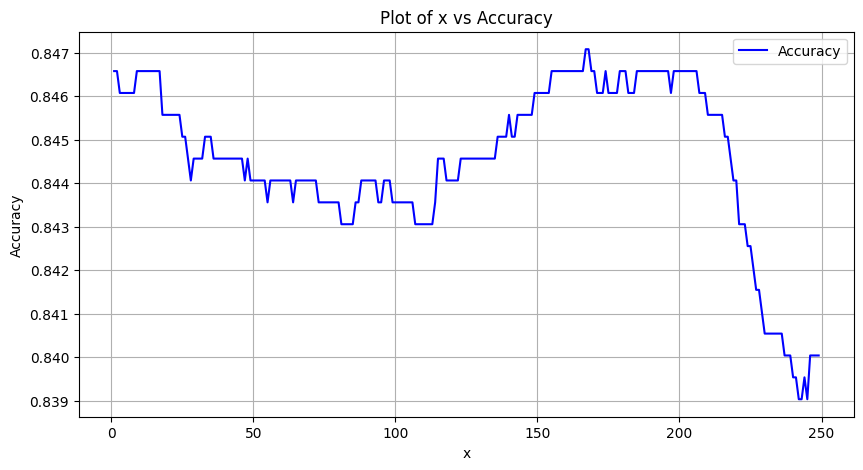

In [234]:
import matplotlib.pyplot as plt
import numpy as np

# shoutout gpt

# Create the plot
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(x, acc, label='Accuracy', color='blue')  # Line plot

# Adding titles and labels
plt.title('Plot of x vs Accuracy')
plt.xlabel('x')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()  # Show legend

# Show the plot
plt.show()

### Vanilla Attack

In [235]:
pert = gb.attack.greedy_grad_descent(A.shape, True, A.device, [budget], grad_fn, flips_per_iteration=25)[0]

print("Clean test acc:   ", gb.metric.accuracy(aux_model(A, X)[test_nodes], y[test_nodes]).item())

A_pert = A + gb.pert.edge_diff_matrix(pert, A)
print("Adversarial edges:", pert.shape[0])
print("Evasion test acc: ", gb.metric.accuracy(aux_model(A_pert, X)[test_nodes], y[test_nodes]).item())

pois_model = make_model()
pois_model.fit((A_pert, X), y, train_nodes, val_nodes, progress=False, **fit_kwargs)
print("Poisoned test acc:", gb.metric.accuracy(pois_model(A_pert, X)[test_nodes], y[test_nodes]).item())

  0%|          | 0/250 [00:00<?, ?it/s]

Clean test acc:    0.8465794324874878
Adversarial edges: 250
Evasion test acc:  0.836016058921814
Poisoned test acc: 0.8123742341995239
